# GTC 2017 Numba Tutorial Notebook 2: CUDA Basics

There are two basic approaches to GPU programming in Numba:

 1. ufuncs/gufuncs (subject of this section)
 2. CUDA Python kernels (subject of next section)
 
We will not go into the CUDA hardware too much in this tutorial, but the most important thing to remember is that the hardware is designed for *data parallelism*.  Maximum throughput is achieved when you are computing the same operations on many different elements at once.  

Universal functions are naturally data parallel, so we will begin with them.

## Universal Functions

NumPy has the concept of universal functions ("ufuncs"), which are functions that can take NumPy arrays of varying dimensions (or scalars) and operate on them element-by-element.

It is probably easiest to show what happens by example.  We'll use the NumPy `add` ufunc to demonstrate what happens:

In [1]:
import numpy as np

a = np.array([1, 2, 3, 4], dtype = np.int64)
b = np.array([10, 20, 30, 40], dtype = np.int64)

np.add(a, b)

array([11, 22, 33, 44], dtype=int64)

Ufuncs also can combine scalars with arrays:

In [2]:
np.add(a, 100)

array([101, 102, 103, 104], dtype=int64)

Arrays of different, but compatible dimensions can also be combined.  The lower dimensional array will be replicated to match the dimensionality of the higher dimensional array

In [3]:
c = np.arange(4*4, dtype = np.int64).reshape((4,4))
print('c:', c)

np.add(b, c)

c: [[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]


array([[10, 21, 32, 43],
       [14, 25, 36, 47],
       [18, 29, 40, 51],
       [22, 33, 44, 55]], dtype=int64)

In the above situation, the `b` array is added to each row of `c`.  If we want to add `b` to each column, we need to transpose it.  There are several ways to do this, but one way is to insert a new axis using `np.newaxis`:

In [4]:
b_col = b[:, np.newaxis]
b_col

array([[10],
       [20],
       [30],
       [40]], dtype=int64)

In [5]:
np.add(b_col, c)

array([[10, 11, 12, 13],
       [24, 25, 26, 27],
       [38, 39, 40, 41],
       [52, 53, 54, 55]], dtype=int64)

The NumPy documentation has a much more extensive discussion of ufuncs:

https://docs.scipy.org/doc/numpy/reference/ufuncs.html

## Making ufuncs for the GPU

Numba has the ability to create compiled ufuncs.  You implement a scalar function of all the inputs, and Numba will figure out the broadcast rules for you.  Generating a ufunc that uses CUDA requires giving an explicit type signature and setting the `target` attribute:

In [6]:
from numba import vectorize


#@vectorize(["float32(float32, float32)"], target='cuda')
@vectorize(['int64(int64, int64)'], target='cuda')
def add_ufunc(x, y):
    return x + y

In [7]:
print('a+b:\n', add_ufunc(a, b))
print()
print('b_col + c:\n', add_ufunc(b_col, c))

a+b:
 [11 22 33 44]

b_col + c:
 [[10 11 12 13]
 [24 25 26 27]
 [38 39 40 41]
 [52 53 54 55]]


A lot of things just happened!  Numba automatically:

 * Compiled a CUDA kernel to execute the ufunc operation in parallel over all the input elements.
 * Allocated GPU memory for the inputs and the output.
 * Copied the input data to the GPU.
 * Executed the CUDA kernel with the correct kernel dimensions given the input sizes.
 * Copied the result back from the GPU to the CPU.
 * Returned the result as a NumPy array on the host.

This is very convenient for testing, but copying data back and forth between the CPU and GPU can be slow and hurt performance.  In the next tutorial notebook, you'll learn about device management and memory allocation.

You might be wondering how fast our simple example is on the GPU?  Let's see:

In [8]:
%timeit np.add(b_col, c)   # NumPy on CPU

1.43 µs ± 17.2 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [9]:
%timeit add_ufunc(b_col, c) # Numba on GPU

1.14 ms ± 105 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Wow, the GPU is *a lot slower* than the CPU??  This is to be expected because we have (deliberately) misused the GPU in several ways in this example:

  * **Our inputs are too small**: the GPU achieves performance through parallelism, operating on thousands of values at once.  Our test inputs have only 4 and 16 integers, respectively.  We need a much larger array to even keep the GPU busy.
  * **Our calculation is too simple**: Sending a calculation to the GPU involves quite a bit of overhead compared to calling a function on the CPU.  If our calculation does not involve enough math operations (often called "arithmetic intensity"), then the GPU will spend most of its time waiting for data to move around.
  * **We copy the data to and from the GPU**: While including the copy time can be realistic for a single function, often we want to run several GPU operations in sequence.  In those cases, it makes sense to send data to the GPU and keep it there until all of our processing is complete.
  * **Our data types are larger than necessary**: Our example uses `int64` when we probably don't need it.  Scalar code using data types that are 32 and 64-bit run basically the same speed on the CPU, but 64-bit data types have a significant performance cost on the GPU.  Basic arithmetic on 64-bit floats can be anywhere from 2x (Pascal-architecture Tesla) to 24x (Maxwell-architecture GeForce) slower than 32-bit floats.  NumPy defaults to 64-bit data types when creating arrays, so it is important to set the `dtype` attribute or use the `ndarray.astype()` method to pick 32-bit types when you need them.
  
  
Given the above, let's try an example that is faster on the GPU:

In [10]:
import math  # Note that for the CUDA target, we need to use the scalar functions from the math module, not NumPy

SQRT_2PI = np.float32((2*math.pi)**0.5)  # Precompute this constant as a float32.  Numba will inline it at compile time.

@vectorize(['float32(float32, float32, float32)'], target='cuda')
def gaussian_pdf(x, mean, sigma):
    '''Compute the value of a Gaussian probability density function at x with given mean and sigma.'''
    return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * SQRT_2PI)

In [11]:
# Evaluate the Gaussian a million times!
x = np.random.uniform(-3, 3, size=1000000).astype(np.float32)
mean = np.float32(0.0)
sigma = np.float32(1.0)

# Quick test
gaussian_pdf(x[0], 0.0, 1.0)

array([0.37319884], dtype=float32)

In [12]:
import scipy.stats # for definition of gaussian distribution
norm_pdf = scipy.stats.norm
%timeit norm_pdf.pdf(x, loc=mean, scale=sigma)

75.5 ms ± 660 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [13]:
%timeit gaussian_pdf(x, mean, sigma)

5.74 ms ± 147 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


That's a pretty large improvement, even including the overhead of copying all the data to and from the GPU.  Ufuncs that use special functions (`exp`, `sin`, `cos`, etc) on large data sets run especially well on the GPU.

## CUDA Device Functions

Ufuncs are great, but you should not have to cram all of your logic into a single function body. You can also create normal functions that are only called from other functions running on the GPU.  (These are similar to CUDA C functions defined with `__device__`.)

Device functions are created with the `numba.cuda.jit` decorator:

In [14]:
from numba import cuda

@cuda.jit(device=True)
def polar_to_cartesian(rho, theta):
    x = rho * math.cos(theta)
    y = rho * math.sin(theta)
    return x, y  # This is Python, so let's return a tuple

@vectorize(['float32(float32, float32, float32, float32)'], target='cuda')
def polar_distance(rho1, theta1, rho2, theta2):
    x1, y1 = polar_to_cartesian(rho1, theta1)
    x2, y2 = polar_to_cartesian(rho2, theta2)
    
    return ((x1 - x2)**2 + (y1 - y2)**2)**0.5

In [15]:
n = 1000000
rho1 = np.random.uniform(0.5, 1.5, size=n).astype(np.float32)
theta1 = np.random.uniform(-np.pi, np.pi, size=n).astype(np.float32)
rho2 = np.random.uniform(0.5, 1.5, size=n).astype(np.float32)
theta2 = np.random.uniform(-np.pi, np.pi, size=n).astype(np.float32)

In [16]:
polar_distance(rho1, theta1, rho2, theta2)

array([0.9253552, 1.4141253, 1.647013 , ..., 0.9177537, 2.3999674,
       1.375088 ], dtype=float32)

Note that the CUDA compiler aggressively inlines device functions, so there is generally no overhead for function calls.  Similarly, the "tuple" returned by `polar_to_cartesian` is not actually created as a Python object, but represented temporarily as a struct, which is then optimized away by the compiler.

## Allowed Python on the GPU

Compared to Numba on the CPU (which is already limited), Numba on the GPU has more limitations.  Supported Python includes:

* `if`/`elif`/`else`
* `while` and `for` loops
* Basic math operators
* Selected functions from the `math` and `cmath` modules
* Tuples

See [the Numba manual](http://numba.pydata.org/numba-doc/latest/cuda/cudapysupported.html) for more details.

# Exercise

Let's build a "zero suppression" function.  A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise.  Let's make some sample data:

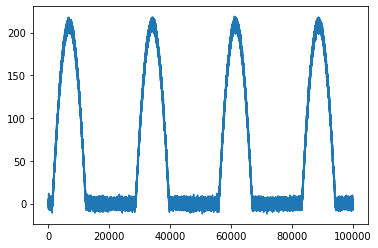

In [17]:
# Hacking up a noisy pulse train
%matplotlib inline
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
waveform = ((pulses * 300) + noise).astype(np.int16)
plt.plot(waveform)

Now try filling in body of this ufunc:

In [18]:
@vectorize(['int16(int16, int16)'], target='cuda')
def zero_suppress(waveform_value, threshold):
    ### Replace this implementation with yours
    result = waveform_value
    ###
    return result

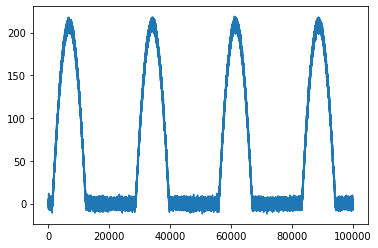

In [19]:
# the noise on the baseline should disappear when zero_suppress is implemented
plt.plot(zero_suppress(waveform, 15.0))